<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum SQL met <a href="https://geopandas.org/en/stable/index.html">GeoPandas</a></h1>
<img src="pics/geopandas_icon.png" width="25%" height="25%"/>

<h2>Environment Variables</h2>

In [1]:
import os
os.environ['export PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] ='notebook'
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

<body> 
<h1 style="background-color:powderblue;color:red;font-size:150%">
Eerst Java apart installeren 
</h1>

</body>

In [2]:
#!(pip list | grep geopandas) || pip install geopandas
!pip install pyspark


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<h2>Imports<h2>

In [3]:
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark.sql
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import geopandas as gpd
#import geoplot
import numpy as np
import contextily as ctx

<h2>Data Visualization</h2>

<h3>Extract</h3>

In [4]:
data_dir = "geo/ref-nuts-2021-01m/"

euPath = data_dir + "NUTS_RG_01M_2021_3035_LEVL_1.json" # griekenland ontbreekt
#euPath = data_dir + "NUTS_LB_2021_3035_LEVL_1.json"
gdf = gpd.read_file(euPath)


<h3>Transform</h3>

In [5]:
gdf.keys()


Index(['id', 'NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME',
       'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'FID', 'geometry'],
      dtype='object')

In [6]:
gdf.crs = "EPSG:3035"
gdfBen = gdf[(gdf.CNTR_CODE == "BE") | (gdf.CNTR_CODE == "NL") | (gdf.CNTR_CODE == "LU")]
gdfCrsBen = gdfBen.to_crs("EPSG:3857")
gdfNl = gdf[gdf.CNTR_CODE == "NL"]
gdfCrsNl = gdfNl.to_crs("EPSG:3857")

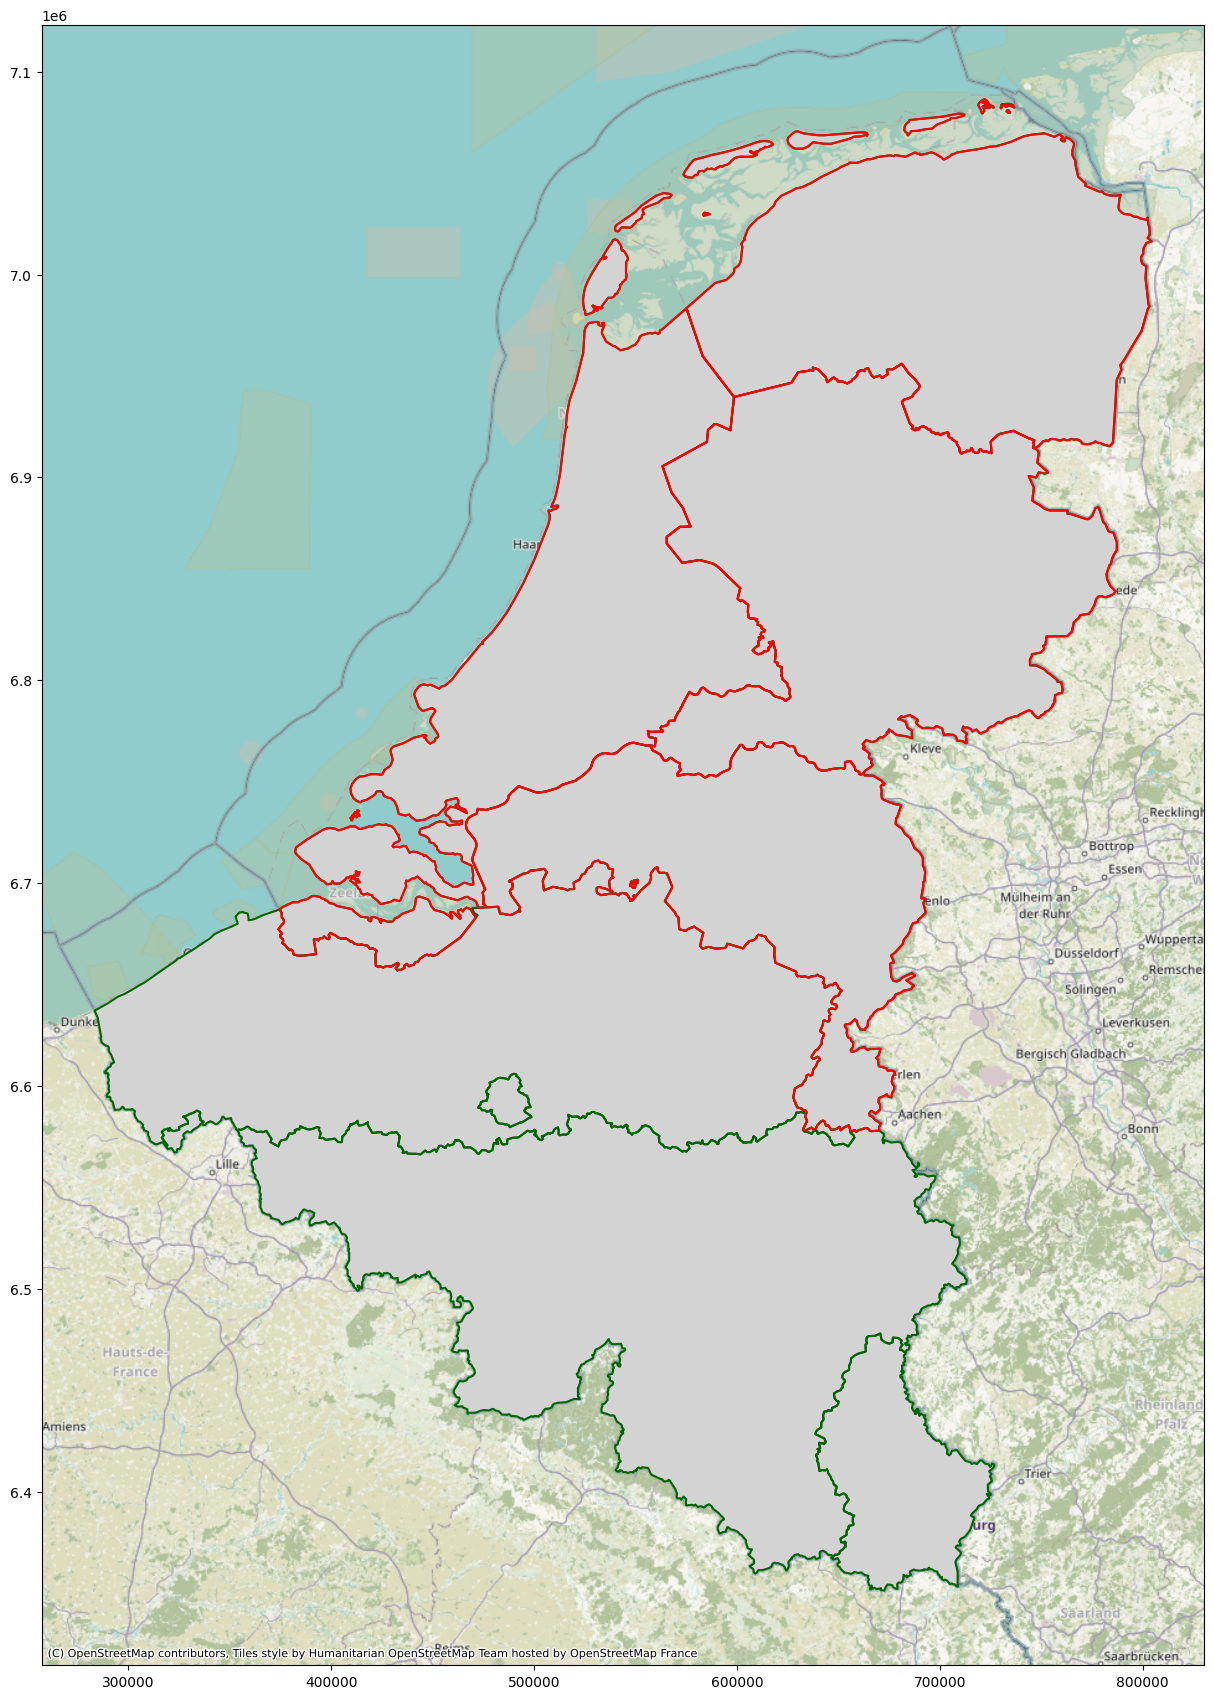

In [7]:
ax = gdfCrsBen.plot(figsize=(15,25), color="lightgray")

# Grenzen Benelux landen
gdfCrsBen.boundary.plot(color="darkgreen", ax=ax)

# Provincies Nederland
gdfCrsNl.boundary.plot(color="red", ax=ax)

# add background map by OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

**Ingezoomed op de Benelux en Nederland gemarkeerd**

<h3>Transform</h3>

<h2>PySpark</h2>

Load

In [8]:
eurCsvFile = "csv/countries_europe.csv"
euCsvFile = "csv/european_union.csv"
eurCodesCsvFile = "csv/country-codes.csv"

In [9]:
# Create a Spark Session
spark = SparkSession.builder.appName('SQL').getOrCreate()

In [10]:
# Create Spark dataframe from csvfile
eurDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
eurDf.printSchema()

root
 |-- zoom: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- ISO numeric: integer (nullable = true)
 |-- land area km: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- continent: string (nullable = true)



FF Freewheelen

In [11]:
# Gebruik van filter
#dir(eurDf)
#help(eurDf.filter)
eurfilt = eurDf.filter(eurDf.population > 10000000)
eurfilt.select(['population','Code']).sort('population').show()


# maar kan ook met een sql function werken.
#  
when = pyspark.sql.functions.when
eurfilt2 = eurfilt.select('Code',when(eurfilt.population >20000000,1).otherwise(-1)).show()
print(eurfilt2)
#Ziet er ook wel grappig uit. 
#eurfilt.population.when()
#(eurfilt.population >20000000,1), 
#1)


+----------+----+
|population|Code|
+----------+----+
|  10403000| BEL|
|  10476000| CZE|
|  10676000| PRT|
|  11000000| GRC|
|  16645000| NLD|
|  21959278| ROU|
|  38500000| POL|
|  45415596| UKR|
|  46505963| ESP|
|  58145000| ITA|
|  62348447| GBR|
|  64768389| FRA|
|  82369000| DEU|
+----------+----+

+----+----------------------------------------------------+
|Code|CASE WHEN (population > 20000000) THEN 1 ELSE -1 END|
+----+----------------------------------------------------+
| UKR|                                                   1|
| FRA|                                                   1|
| ESP|                                                   1|
| DEU|                                                   1|
| POL|                                                   1|
| ITA|                                                   1|
| GBR|                                                   1|
| ROU|                                                   1|
| GRC|                           

In [12]:
# Create a view. 
eurDf.createOrReplaceTempView('countries')
help(eurDf.createOrReplaceTempView)
#Wat is dit? Ik snap het eigenlijk nog steeds niet. 

Help on method createOrReplaceTempView in module pyspark.sql.dataframe:

createOrReplaceTempView(name: str) -> None method of pyspark.sql.dataframe.DataFrame instance
    Creates or replaces a local temporary view with this :class:`DataFrame`.
    
    The lifetime of this temporary table is tied to the :class:`SparkSession`
    that was used to create this :class:`DataFrame`.
    
    .. versionadded:: 2.0.0
    
    Examples
    --------
    >>> df.createOrReplaceTempView("people")
    >>> df2 = df.filter(df.age > 3)
    >>> df2.createOrReplaceTempView("people")
    >>> df3 = spark.sql("select * from people")
    >>> sorted(df3.collect()) == sorted(df2.collect())
    True
    >>> spark.catalog.dropTempView("people")
    True



**query op het dataframe via <i>methods</i>**

In [13]:
eurDf.select("Code").show(10)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows



**<i>SQL</i> query op het dataframe**

In [14]:
import time
s= time.time()
eurDf.select('Code').show(10)
e= time.time()
print(e-s)

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows

0.10543608665466309


In [15]:



s= time.time()
countriesQuery = """
    SELECT Code
    FROM countries
    
"""

eurCodes = spark.sql(countriesQuery)
eurCodes.show(10)
e = time.time()
print(e-s)


+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows

0.15714049339294434


In [16]:
eurDf.select("Code").show(10)
eurDf.select("Code").show()


+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
+----+
only showing top 10 rows

+----+
|Code|
+----+
| UKR|
| FRA|
| ESP|
| SWE|
| DEU|
| FIN|
| NOR|
| POL|
| ITA|
| GBR|
| ROU|
| BLR|
| GRC|
| BGR|
| ISL|
| PRT|
| CZE|
| DNK|
| HUN|
| SRB|
+----+
only showing top 20 rows



In [17]:
eurDf.write.json('./test.json')
# Wegschrijven werkt niet. Op stackoverflow kom ik vage meldingen tegen met advies om hadoop files aan te passen

AnalysisException: path file:/c:/Users/marcr/MakeAIWork3/opdrachten/practica/week14/test.json already exists.

<h3>Exercise 1</h3>
<p>
Maak op dezelfde manier dataframes euDf en eurCodesDf aan door het importeren vanuit de csv-files
</p>

In [18]:

#eurCsvFile = "csv/countries_europe.csv"
#euCsvFile = "csv/european_union.csv"
#eurCodesCsvFile = "csv/country-codes.csv"
eurCsvDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
euCsvDf = spark.read.csv(euCsvFile, inferSchema=True, header=True)
cCodesDf = spark.read.csv(eurCodesCsvFile, inferSchema=True, header=True)
cCodesDf.printSchema()
eurCsvDf.printSchema()
help(cCodesDf['FIFA'])


root
 |-- FIFA: string (nullable = true)
 |-- Dial: string (nullable = true)
 |-- ISO3166-1-Alpha-3: string (nullable = true)
 |-- MARC: string (nullable = true)
 |-- is_independent: string (nullable = true)
 |-- ISO3166-1-numeric: integer (nullable = true)
 |-- GAUL: string (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- WMO: string (nullable = true)
 |-- ISO3166-1-Alpha-2: string (nullable = true)
 |-- ITU: string (nullable = true)
 |-- IOC: string (nullable = true)
 |-- DS: string (nullable = true)
 |-- UNTERM Spanish Formal: string (nullable = true)
 |-- Global Code: boolean (nullable = true)
 |-- Intermediate Region Code: integer (nullable = true)
 |-- official_name_fr: string (nullable = true)
 |-- UNTERM French Short: string (nullable = true)
 |-- ISO4217-currency_name: string (nullable = true)
 |-- Developed / Developing Countries: string (nullable = true)
 |-- UNTERM Russian Formal: string (nullable = true)
 |-- UNTERM English Short: string (nullable = true)
 |-- IS

<h3>Exercise 2a</h3>
<p>
    Maak een <u>koppeling</u> tussen <u>euDf</u> en <u>eurCodesDf</u> via kolom <u>Code</u> en <u>ISO3166-1-Alpha-3</u> 
</p>

In [19]:
eurCsvDf.show(5)
euCsvDf.show(5)
euCsvDf.join(eurCsvDf,'Code').show(5)
eulargeDf = euCsvDf.join(cCodesDf,euCsvDf['Code']==cCodesDf['ISO3166-1-Alpha-3'])

+----+-------+------------+----+-----------+------------+----------+--------+---------+---------+
|zoom|   name|abbreviation|Code|ISO numeric|land area km|population|latitude|longitude|continent|
+----+-------+------------+----+-----------+------------+----------+--------+---------+---------+
|   3|Ukraine|        Ukr.| UKR|        804|    603700.0|  45415596|    49.0|     32.0|       eu|
|   3| France|         Fr.| FRA|        250|    547030.0|  64768389|    46.0|      2.0|       eu|
|   3|  Spain|       Spain| ESP|        724|    504782.0|  46505963|    40.0|     -4.0|       eu|
|   3| Sweden|        Swe.| SWE|        752|    449964.0|   9045000|    62.0|     15.0|       eu|
|   3|Germany|        Ger.| DEU|        276|    357021.0|  82369000|    51.5|     10.5|       eu|
+----+-------+------------+----+-----------+------------+----------+--------+---------+---------+
only showing top 5 rows

+----+--------+-------------------+
|Code|    Name|       Member-Since|
+----+--------+------

In [20]:
# Oplossing
# zoeken op internet levert op dat samenvoegen met de methode join kan. 
#



eulargeDf = euCsvDf.join(cCodesDf,euCsvDf['Code']==cCodesDf['ISO3166-1-Alpha-3'])
eulargeDf['Code','ISO3166-1-Alpha-3'].show(10)
eulargeDf['WMO',].show(10)
eulargeDf.printSchema()

# lengte (aantal rijen) achterhalen kan met de methode count.
print(eulargeDf.count())
print(euCsvDf.count())
print(cCodesDf.count())


+----+-----------------+
|Code|ISO3166-1-Alpha-3|
+----+-----------------+
| AUT|              AUT|
| BEL|              BEL|
| BGR|              BGR|
| HRV|              HRV|
| CYP|              CYP|
| CZE|              CZE|
| DNK|              DNK|
| EST|              EST|
| FIN|              FIN|
| FRA|              FRA|
+----+-----------------+
only showing top 10 rows

+---+
|WMO|
+---+
| OS|
| BX|
| BU|
| RH|
| CY|
| CZ|
| DN|
| EO|
| FI|
| FR|
+---+
only showing top 10 rows

root
 |-- Code: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Member-Since: timestamp (nullable = true)
 |-- FIFA: string (nullable = true)
 |-- Dial: string (nullable = true)
 |-- ISO3166-1-Alpha-3: string (nullable = true)
 |-- MARC: string (nullable = true)
 |-- is_independent: string (nullable = true)
 |-- ISO3166-1-numeric: integer (nullable = true)
 |-- GAUL: string (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- WMO: string (nullable = true)
 |-- ISO3166-1-Alpha-2: string

<h3>Exercise 2b</h3>

<h4>Gegeven</h4>

<p>De dataset gdf bevat tweeletterige landcodes die je ook kunt terugvinden in de dataset <u>eurCodesDf</u></>

In [21]:
gdf.CNTR_CODE.tolist()[:10]

['CY', 'DE', 'CH', 'FR', 'BG', 'DE', 'EL', 'EL', 'DE', 'BE']

<h4>Gevraagd</h4>
<p>
    Maak een geopandas dataframe <u>gdfEu</u> gebaseerd op <u>gdf</u> en markeer hierin de EU landen met <span style="color:red">rood</span>.
    <strong>Hint</strong>Gebruik de koppeling uit 2a voor het verkrijgen van de tweeletterige landcodes van EU landen en filter daarmee het geodataframe.
</p>

<h4>Oplossing</h4>

In [22]:
ladiela  = eulargeDf.select(eulargeDf.FIFA.startswith('A').alias('yo'))
print(ladiela)
ladiela.show()


DataFrame[yo: boolean]
+-----+
|   yo|
+-----+
| true|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
|false|
+-----+
only showing top 20 rows



In [24]:
# Oplossing
if True:
    print(eulargeDf.columns)

    #je kan koppelen met de spark database via een ISO-norm.
    # Maar welke dan?  
    # Eerst even kijken welke ISO data er zijn 
    # eulargeDf.select(eulargeDf.columns.filter(_.startsWith("ISO")).map(eulargeDf(_)) : _*).show
    # Dit werkt niet.
    # kijken of het met map kan..
    def isoinname(s):
        if 'ISO' in s:
            return s
    x=map(isoinname, eulargeDf.columns)
    for a in x:
        print(a)

    # ...filter werkt nog beter.
    y=filter(isoinname, eulargeDf.columns)
    for b in y:
        print(b)
    #xx
    # 'ISO3166-1-Alpha-2'
    #eulargeDf.columns.filter

print(eulargeDf['ISO3166-1-Alpha-2',].show(10))
tempsdf = eulargeDf['ISO3166-1-Alpha-2',]
tempdf= tempsdf.toPandas()
eulargeDf
tempsdf.columns
print(gdf.keys())
print(gdf['CNTR_CODE'])
print(tempsdf['ISO3166-1-Alpha-2'])

for a in tempdf['ISO3166-1-Alpha-2']:
    print(gdf[gdf['CNTR_CODE'] ==a] ) 

ending = [gdf[gdf['CNTR_CODE'] ==a] for a in tempdf['ISO3166-1-Alpha-2']] 

#OPMERKING 1 DIT MOET NETTER KUNNEN, MET EEN GEODATAFRAME ALS UITKOMST. 
# OPMERKING 2, GRIEKENLAND ONTBREEKT. HOE KAN DAT  
print(ending)

#print(tempdf['ISO3166-1-Alpha-2'][1] in gdf['CNTR_CODE'] )
#gdf[gdf['CNTR_CODE']==tempsdf['ISO3166-1-Alpha-2']]
#gdf




['Code', 'Name', 'Member-Since', 'FIFA', 'Dial', 'ISO3166-1-Alpha-3', 'MARC', 'is_independent', 'ISO3166-1-numeric', 'GAUL', 'FIPS', 'WMO', 'ISO3166-1-Alpha-2', 'ITU', 'IOC', 'DS', 'UNTERM Spanish Formal', 'Global Code', 'Intermediate Region Code', 'official_name_fr', 'UNTERM French Short', 'ISO4217-currency_name', 'Developed / Developing Countries', 'UNTERM Russian Formal', 'UNTERM English Short', 'ISO4217-currency_alphabetic_code', 'Small Island Developing States (SIDS)', 'UNTERM Spanish Short', 'ISO4217-currency_numeric_code', 'UNTERM Chinese Formal', 'UNTERM French Formal', 'UNTERM Russian Short', 'M49', 'Sub-region Code', 'Region Code', 'official_name_ar', 'ISO4217-currency_minor_unit', 'UNTERM Arabic Formal', 'UNTERM Chinese Short', 'Land Locked Developing Countries (LLDC)', 'Intermediate Region Name', 'official_name_es', 'UNTERM English Formal', 'official_name_cn', 'official_name_en', 'ISO4217-currency_country_name', 'Least Developed Countries (LDC)', 'Region Name', 'UNTERM Arab

In [40]:
eurCsvDf.where()

AnalysisException: Except can only be performed on tables with the same number of columns, but the first table has 10 columns and the second table has 3 columns;
'Except false
:- Relation [zoom#127,name#128,abbreviation#129,Code#130,ISO numeric#131,land area km#132,population#133,latitude#134,longitude#135,continent#136] csv
+- Relation [Code#164,Name#165,Member-Since#166] csv


In [ ]:
f= tempsdf['ISO3166-1-Alpha-2']=='GR'
f= tempsdf.toPandas()
#print(f)

#print(tempdf['ISO3166-1-Alpha-2'])
print(gdf['CNTR_CODE'])
gdf.to_csv('C:/temp/temp.xlsx')

0      AL
1      AT
2      AT
3      AT
4      BE
       ..
120    UK
121    UK
122    UK
123    UK
124    NO
Name: CNTR_CODE, Length: 125, dtype: object


In [ ]:
for end in ending:
    print(end['CNTR_CODE'])
    #print('yes')

1    AT
2    AT
3    AT
Name: CNTR_CODE, dtype: object
4    BE
5    BE
6    BE
Name: CNTR_CODE, dtype: object
7    BG
8    BG
Name: CNTR_CODE, dtype: object
57    HR
Name: CNTR_CODE, dtype: object
10    CY
Name: CNTR_CODE, dtype: object
11    CZ
Name: CNTR_CODE, dtype: object
28    DK
Name: CNTR_CODE, dtype: object
29    EE
Name: CNTR_CODE, dtype: object
41    FI
42    FI
Name: CNTR_CODE, dtype: object
43    FR
44    FR
45    FR
46    FR
47    FR
48    FR
49    FR
50    FR
51    FR
52    FR
53    FR
54    FR
55    FR
56    FR
Name: CNTR_CODE, dtype: object
12    DE
13    DE
14    DE
15    DE
16    DE
17    DE
18    DE
19    DE
20    DE
21    DE
22    DE
23    DE
24    DE
25    DE
26    DE
27    DE
Name: CNTR_CODE, dtype: object
Series([], Name: CNTR_CODE, dtype: object)
58    HU
59    HU
60    HU
Name: CNTR_CODE, dtype: object
61    IE
Name: CNTR_CODE, dtype: object
63    IT
64    IT
65    IT
66    IT
67    IT
Name: CNTR_CODE, dtype: object
71    LV
Name: CNTR_CODE, dtype: object
69   

c:\Users\marcr\MakeAIWork3\env_geopan\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


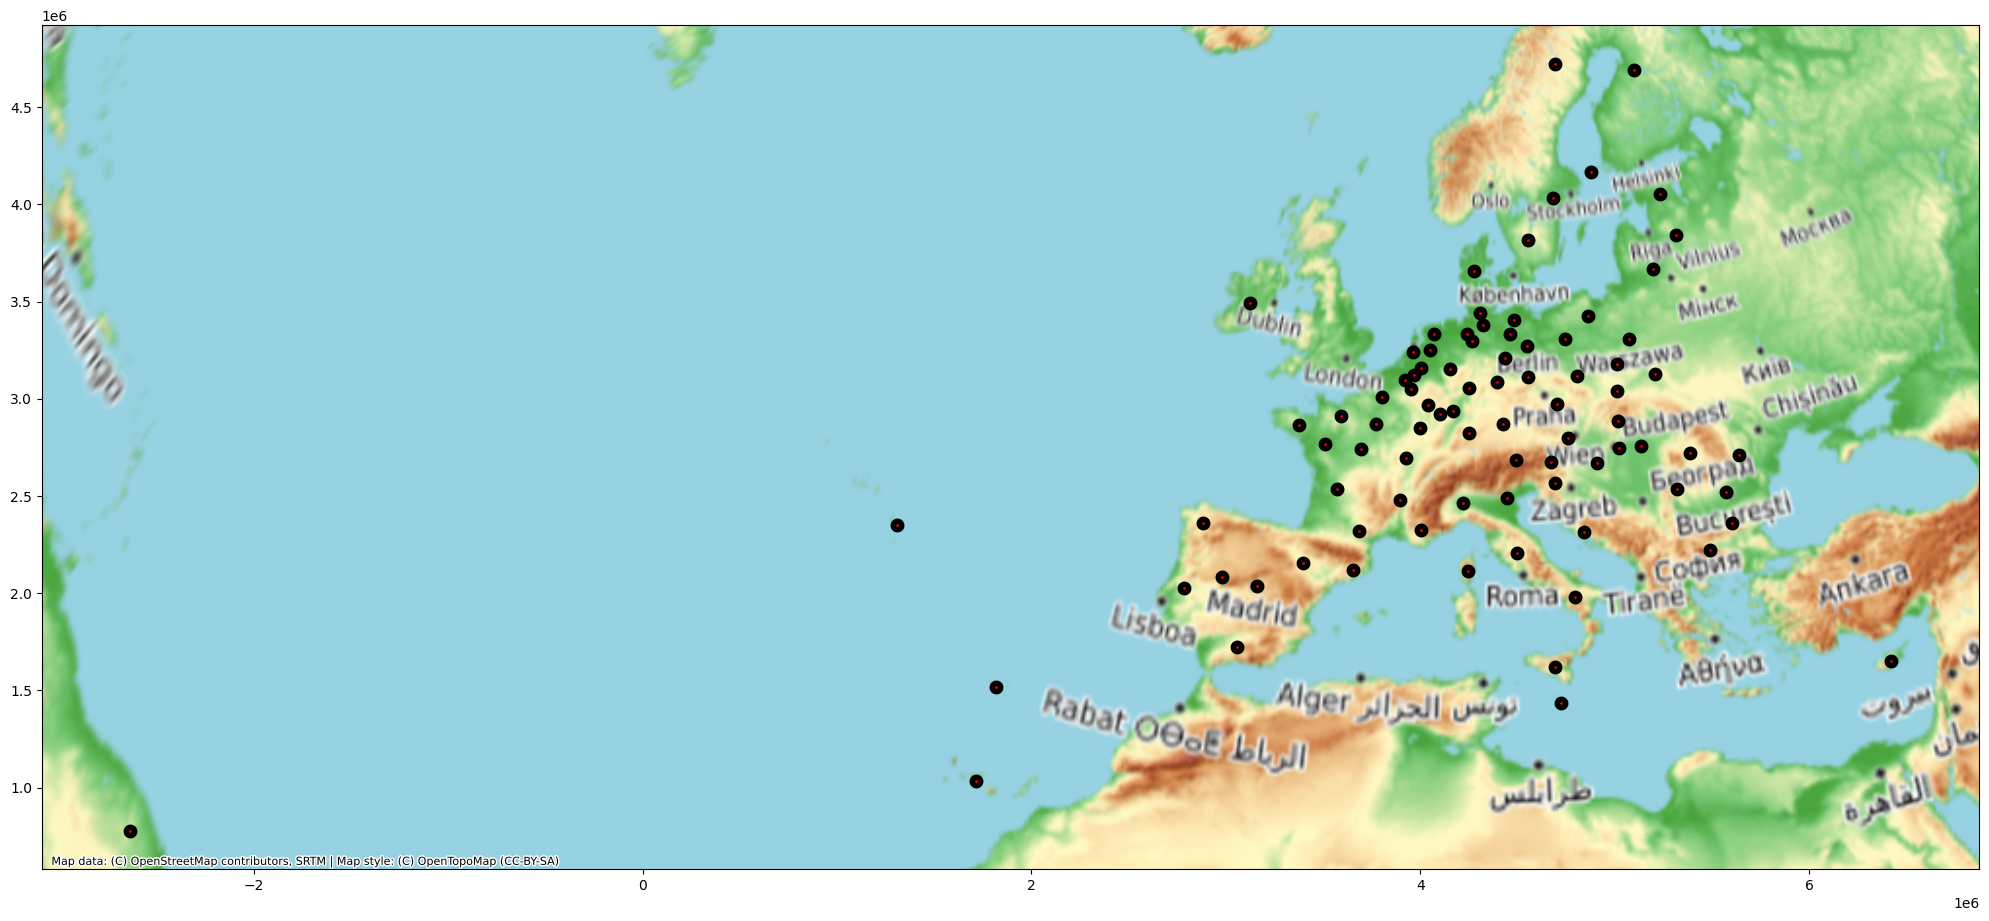

In [ ]:
gdf[gdf['CNTR_CODE'] ==a].shape
plt.figure(figsize=[25,18])
ax=plt.gca()
source = ctx.providers.OpenTopoMap

#ctx.plot_map(ax=ax,place=pl,axis_off=False,crs='EPSG:3857') # crs kun je alleen opgeven in add_basemap?
if True:
    for end in ending:
        end.plot(color='red',ax=ax,edgecolor='k',linewidth=4)
#ctx.add_basemap(ax=ax,crs='EPSG:3035',source=source,zoom=3)
ctx.add_basemap(ax=ax,crs=end.crs,source=source,zoom=3)

pl = ctx.place.Place('europa',source=source,path='europa.tif')

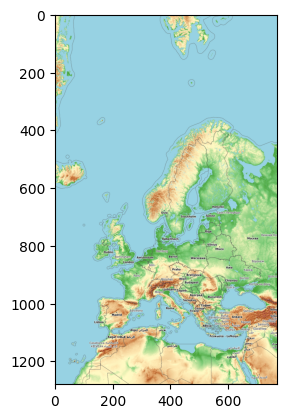

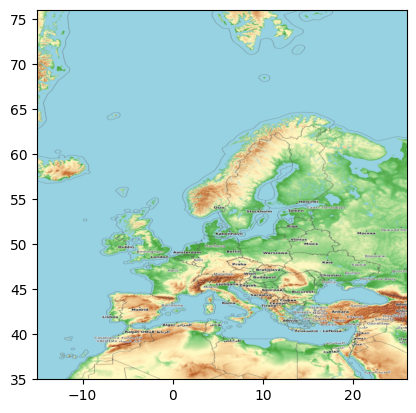

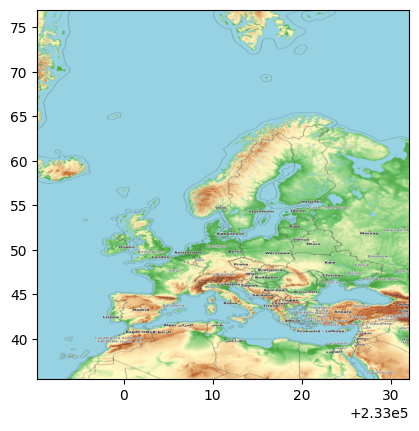

In [ ]:
#ruw plotten van een tif afkomstig uit contextily.Place object
pl = ctx.place.Place('europa',source=source,path='europa.tif')
im = plt.imread('europa.tif')
plt.imshow(im)

# naar pseudo mercator 
plt.figure()
im_new = ctx.warp_tiles(im[:,:,:4],pl.bbox,t_crs="epsg:3857")
plt.imshow(im_new[0],extent=im_new[1])

plt.figure()
im_new = ctx.warp_tiles(im[:,:,:4],pl.bbox,t_crs="epsg:3025")
plt.imshow(im_new[0],extent=im_new[1])



**References**
<ul>
    <li>        
        <a href="https://towardsdatascience.com/pyspark-and-sparksql-basics-6cb4bf967e53">Pyspark SQL basics</a>       
    </li>
    <li>
        <a href="https://ec.europa.eu/eurostat/web/main/home">Eurostat</a>
    </li>
</ul>    